# Hyper-parameter tuning – Regression Dataset  
This notebook finds the best parameters for:

* **Bagging** RandomForestRegressor  
* **Boosting** XGBRegressor  
* **Stack meta learner** Ridge α in the RF+XGB+OLS stack

Results are saved to `configs/` folder.

## Setup & Imports

In [ ]:
import yaml, pathlib, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.model_selection import (
    RepeatedKFold,
    KFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
)
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from optuna.visualization import plot_optimization_history

from bagging_boosting_stacking_study.constants import SEED
from bagging_boosting_stacking_study.data.loaders import load_dataset
from bagging_boosting_stacking_study.configs import save_params, load_params

DATASET_NAME = "friedman1"

In [2]:
# dark theme across plots
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

## Load Clean Dataset

In [3]:
df = load_dataset(DATASET_NAME, raw=False)

### train test split

In [4]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED)

In [5]:
train_df.shape

(4500, 8)

In [6]:
test_df.shape

(500, 8)

## Bagging

### pipeline



### hyper-parameter tuning

In [ ]:
# Split X and y
y = train_df["target"].values
X = train_df.drop(columns="target").values

# Cross-validation strategy: 5-fold, repeated twice (10 scores / trial)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)


# Objective function for Optuna
def objective(trial):
    # Hyper-parameter search space

    # (a) Ensemble size
    n_estimators = trial.suggest_categorical(
        "n_estimators", [50, 100, 200, 400, 600, 900, 1500, 2000, 3000]
    )

    # (b) Depth: cap or unlimited
    if trial.suggest_categorical("cap_depth", [True, False]):
        max_depth = trial.suggest_int("max_depth", 3, 20)
    else:
        max_depth = None

    # (c) Tree-shape regularisation
    min_samples_split = trial.suggest_int("min_samples_split", 2, 32)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15)

    # (d) Feature subsampling (7 predictors -> all predictors)
    max_features = trial.suggest_int("max_features", 2, 7, step=1)

    # (e) Bootstrap & row subsampling
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_samples = (
        trial.suggest_float("max_samples", 0.3, 1.0, step=0.1) if bootstrap else None
    )

    # (f) Impurity, pruning
    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "absolute_error"]
    )
    ccp_alpha = trial.suggest_float("ccp_alpha", 1e-6, 1e-3, log=True)

    # (g) Out-of-bag score only legal when bootstrap
    oob_score = bootstrap and trial.suggest_categorical("oob_score", [True, False])

    # Model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        max_samples=max_samples,
        criterion=criterion,
        ccp_alpha=ccp_alpha,
        oob_score=oob_score,
        n_jobs=-1,
        random_state=SEED,
    )

    # CV evaluation
    # NOTE: scikit-learn returns negative RMSE so I negate “neg_root_mean_squared_error”
    # again to get a positive value to minimise.
    rmse = -cross_val_score(
        rf, X=X, y=y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


# Create & run the study
study_rf = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),  # reproducible search
    pruner=HyperbandPruner(),  # aggressive early stopping
    study_name="RF_reproducible",
)

# Robust search: either n_trials or timeout
study_rf.optimize(objective, n_trials=200, show_progress_bar=True)
# study.optimize(objective, timeout=3600, show_progress_bar=True)

# Inspect the result
print("Best RMSE:", study_rf.best_value)
print("Best parameters:", study_rf.best_params)

[I 2025-05-24 14:31:11,676] A new study created in memory with name: RF_reproducible


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-05-24 14:31:27,127] Trial 0 finished with value: 2.147126313554667 and parameters: {'n_estimators': 100, 'cap_depth': True, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 3, 'bootstrap': False, 'criterion': 'absolute_error', 'ccp_alpha': 0.0009987143703359962}. Best is trial 0 with value: 2.147126313554667.
[I 2025-05-24 14:31:33,859] Trial 1 finished with value: 1.9039394705665376 and parameters: {'n_estimators': 2000, 'cap_depth': True, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': 2, 'bootstrap': True, 'max_samples': 0.7, 'criterion': 'squared_error', 'ccp_alpha': 6.22520256707372e-06, 'oob_score': False}. Best is trial 1 with value: 1.9039394705665376.
[I 2025-05-24 14:31:34,103] Trial 2 finished with value: 1.1223600261992956 and parameters: {'n_estimators': 50, 'cap_depth': False, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 3, 'bootstrap': True, 'max_samples': 0.4, 'criterion': 'squared_

In [15]:
fig = plot_optimization_history(study_rf)
fig.show()

In [16]:
print("Best RMSE :", study_rf.best_value)

Best RMSE : 0.8284886083457236


In [17]:
study_rf.best_params

{'n_estimators': 3000,
 'cap_depth': False,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 3,
 'bootstrap': False,
 'criterion': 'absolute_error',
 'ccp_alpha': 1.698347150346809e-05}

In [ ]:
# Save best params to .yaml
save_params(DATASET_NAME, "rf", study_rf.best_value, study_rf.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\friedman1_rf.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/friedman1_rf.yaml')

In [ ]:
# Copy Optuna's best parameters
best_rf_params = study_rf.best_params.copy()
cap_flag = best_rf_params.pop("cap_depth")  # remove it; returns True/False
max_depth = best_rf_params.pop("max_depth", None)  # may or may not exist

best_rf_params["max_depth"] = max_depth if cap_flag else None
best_rf_params.update(
    {
        "random_state": SEED,  # full reproducibility
        "n_jobs": -1,  # or 1 for bit-perfect runs
    }
)

# Fit on all 900 training rows
rf_final = RandomForestRegressor(**best_rf_params)
rf_final.fit(X, y)

RandomForestRegressor(bootstrap=False, ccp_alpha=1.698347150346809e-05,
                      criterion='absolute_error', max_features=3,
                      n_estimators=3000, n_jobs=-1, random_state=333)

## Boosting

In [20]:
# Split X and y
y = train_df["target"].values
X = train_df.drop(columns="target").values

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)


# Objective function
def objective(trial):
    # Core boosting configuration
    n_estimators = trial.suggest_int("n_estimators", 100, 3000, step=50)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 12)  # depth of each tree
    min_child_weight = trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True)

    # Sub-sampling for variance reduction
    subsample = trial.suggest_float("subsample", 0.3, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.3, 1.0, step=0.1)

    # Regularisation
    gamma = trial.suggest_float("gamma", 0.0, 2.0)  # minimum loss-reduction to split
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 50.0, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 5.0)

    # Control for imbalanced data
    # NOTE: maximum delta step we allow each tree's weight estimation; helps with class
    # imbalance
    max_delta_step = trial.suggest_int("max_delta_step", 0, 10)

    # Tree growth algorithm
    # NOTE: 'depthwise' grows balanced trees; 'lossguide' focuses on high-loss regions
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if grow_policy == "lossguide":
        max_depth = 0  # NOTE: depth limit disabled when optimizing by leaf count
        # NOTE: maximum number of leaves; more leaves -> more complex splits
        max_leaves = trial.suggest_int("max_leaves", 16, 256, step=16)
    else:
        max_leaves = 0  # NOTE: not used in 'depthwise' mode

    # Build the model
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        max_delta_step=max_delta_step,
        grow_policy=grow_policy,
        objective="reg:squarederror",  # regression objective minimizing squared error
        tree_method="hist",  # fast histogram grower
        random_state=SEED,
        n_jobs=-1,
    )

    # CV evaluation (neg RMSE -> minimise RMSE)
    rmse = -cross_val_score(
        xgb, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


# Create & run the Optuna study
study_xgb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=HyperbandPruner(),  # stops weak configs early
    study_name="XGB_reproducible",
)

study_xgb.optimize(objective, n_trials=2000, show_progress_bar=True)
# study.optimize(objective, timeout=3600, show_progress_bar=True)

print("Best RMSE :", study_xgb.best_value)
print("Best parameters:", study_xgb.best_params)

[I 2025-05-24 23:20:44,958] A new study created in memory with name: XGB_reproducible


  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2025-05-24 23:20:48,321] Trial 0 finished with value: 0.8640428059961469 and parameters: {'n_estimators': 1700, 'learning_rate': 0.06392921059081536, 'max_depth': 2, 'min_child_weight': 0.020958259416674875, 'subsample': 0.5, 'colsample_bytree': 0.3, 'gamma': 0.20906037634494168, 'reg_lambda': 0.0028698286253091595, 'reg_alpha': 1.2270165725677717, 'max_delta_step': 9, 'grow_policy': 'lossguide', 'max_leaves': 64}. Best is trial 0 with value: 0.8640428059961469.
[I 2025-05-24 23:20:51,220] Trial 1 finished with value: 3.5367465065297785 and parameters: {'n_estimators': 700, 'learning_rate': 0.002706081931722294, 'max_depth': 6, 'min_child_weight': 5.847260906636588, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'gamma': 1.9996275326085353, 'reg_lambda': 2.587870367125735, 'reg_alpha': 2.421143372711623, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8640428059961469.
[I 2025-05-24 23:20:56,196] Trial 2 finished with value: 4.2652317360873

In [21]:
fig = plot_optimization_history(study_xgb)
fig.show()

In [22]:
print("Best RMSE :", study_xgb.best_value)

Best RMSE : 0.5308291244292738


In [23]:
study_xgb.best_params

{'n_estimators': 3000,
 'learning_rate': 0.02010903042778187,
 'max_depth': 2,
 'min_child_weight': 0.5318510238039913,
 'subsample': 0.3,
 'colsample_bytree': 0.3,
 'gamma': 0.4511270522982942,
 'reg_lambda': 1.729558045703729,
 'reg_alpha': 0.49622295918270054,
 'max_delta_step': 3,
 'grow_policy': 'depthwise'}

In [ ]:
# Save best params to .yaml
save_params(DATASET_NAME, "xgb", study_xgb.best_value, study_xgb.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\friedman1_xgb.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/friedman1_xgb.yaml')

In [25]:
best_params = study_xgb.best_params.copy()
best_params.update(
    {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "random_state": SEED,
        "n_jobs": -1,
    }
)
xgb_final = XGBRegressor(**best_params)
xgb_final.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.4511270522982942,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, learning_rate=0.02010903042778187,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=3, max_depth=2, max_leaves=None,
             min_child_weight=0.5318510238039913, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=-1, num_parallel_tree=None, ...)

## Stacking

In [ ]:
y = train_df["target"].values
X = train_df.drop(columns="target").values

# Fixed base learners (best params from earlier Optuna runs)
rf_best = load_params(dataset=DATASET_NAME, model="rf")["params"]
cap_flag = rf_best.pop("cap_depth")  # remove it; returns True/False
max_depth = rf_best.pop("max_depth", None)  # may or may not exist
rf_best["max_depth"] = max_depth if cap_flag else None
rf_best.update(dict(random_state=SEED, n_jobs=-1))
rf_base = RandomForestRegressor(**rf_best)

xgb_best = load_params(dataset=DATASET_NAME, model="xgb")["params"]
xgb_best.update(
    dict(objective="reg:squarederror", tree_method="hist", random_state=SEED, n_jobs=-1)
)
xgb_base = XGBRegressor(**xgb_best)

ols_base = Pipeline([("sc", StandardScaler()), ("ols", LinearRegression())])

base_estimators = [
    ("rf", rf_base),
    ("xgb", xgb_base),
    ("ols", ols_base),
]

# Standard KFold (no repeats) so cross_val_predict works
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute OOF predictions
preds = []
for name, est in tqdm(base_estimators, desc="OOF learners"):
    # set n_jobs if estimator supports it
    if "n_jobs" in est.get_params():
        est.set_params(n_jobs=1)
    oof = cross_val_predict(est, X, y, cv=cv, n_jobs=-1, verbose=1)
    preds.append(oof)
X_meta = np.column_stack(preds)

# Search alpha with RidgeCV over the same log‐space
alphas = np.concatenate(([0.0], np.logspace(-8, 2, 200)))
ridge_cv = RidgeCV(
    alphas=alphas, cv=cv, scoring="neg_root_mean_squared_error", store_cv_values=False
).fit(X_meta, y)

best_alpha = ridge_cv.alpha_
best_rmse = np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))
print(f"Chosen alpha: {best_alpha:.4g}")
print(f"OOF RMSE: {best_rmse}")

c:\code\venvs\repos\repo-3.12-bagging-boosting-stacking-study\Lib\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Chosen alpha: 0
OOF RMSE: 0.5303721956193583


In [25]:
print(f"Best RMSE: {np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))}")

Best RMSE: 0.5303721956193583


In [26]:
print(f"Best lambda (alpha): {ridge_cv.alpha_}")

Best lambda (alpha): 0.0


In [ ]:
# Save best params to .yaml
save_params(
    dataset=DATASET_NAME, 
    model="stack", 
    metric=np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta))), 
    params={"alpha": float(ridge_cv.alpha_)}
)

Params saved to src\bagging_boosting_stacking_study\configs\friedman1_stack.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/friedman1_stack.yaml')

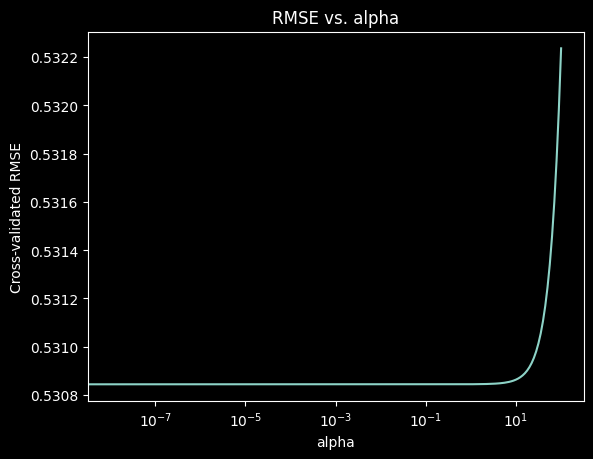

In [21]:
rmses = []
for a in alphas:
    scores = cross_val_score(
        Ridge(alpha=a),
        X_meta,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    rmses.append(-scores.mean())

plt.figure()
plt.xscale("log")
plt.plot(alphas, rmses)
plt.xlabel("alpha")
plt.ylabel("Cross-validated RMSE")
plt.title("RMSE vs. alpha")
plt.show()

In [30]:
best_alpha = ridge_cv.alpha_

meta_final = Pipeline(
    [("sc", StandardScaler()), ("ridge", Ridge(alpha=best_alpha, random_state=SEED))]
)

stack_final = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_final,
    passthrough=False,
    n_jobs=-1,
)

stack_final.fit(X, y)

KeyboardInterrupt: 